In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as pt

from mcmc import mcmc
import densities
import my_problemLR

%matplotlib notebook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameter for the problem

In [3]:
# parameters for the problem
Npoint = 100

# data abscissa {Xi}
my_problemLR.Xi = np.random.rand(Npoint)
my_problemLR.sigmad = 0.1 # sec

## Linear regression coefficients to be found

In [4]:
slope = 2.
intercept = 1.

## Create "observed data"

In [5]:
#  Data value = {Yi}
my_problemLR.Yi = slope * my_problemLR.Xi + intercept + np.random.randn(Npoint) * my_problemLR.sigmad

## Trial solution

In [6]:
X0 = np.array([10., 10.])

## Run MCMC

In [7]:
# set the step Dernier param : 'Gaus' ou autre
step = np.array([0.01, 0.01])# *2 or *5 or *10

niter = 100000


mout, mMAP, accrate = mcmc(my_problemLR.logprior, my_problemLR.loglikelyhood,
                           densities.generate, densities.logproposal, X0, niter, step, 'Gaus')

## Plot solutions

<IPython.core.display.Javascript object>


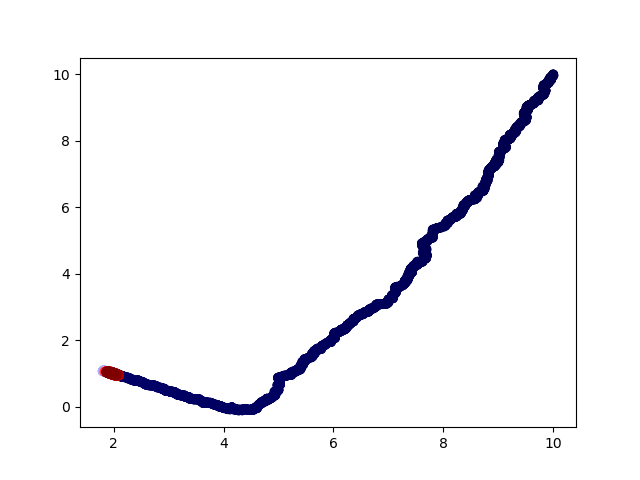

acceptanceRate 0.64968
Solution with highest probability is  [1.97316977 1.01051125]


In [8]:
x=mout[:,0]
y=mout[:,1]
pt.figure()
print('acceptanceRate',accrate)
pt.scatter(x,y,cmap= pt.get_cmap('seismic'), c = np.arange(len(x))/len(x))
print('Solution with highest probability is ',mMAP)

Permet de suivre l'avancement de l'iération, commencement à (10,10) et finis à environ (2,1). Valeur plus haut trés sombre car la majorité se trouve à gauche. Système trés convergent.

### Defining the burning period

<IPython.core.display.Javascript object>


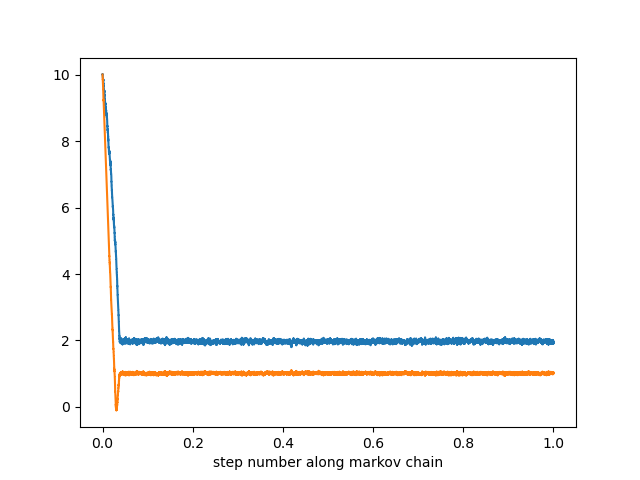

In [9]:
pt.figure()
iter=np.arange(0.,niter)
pt.plot(iter/niter,mout[:,0],iter/niter,mout[:,1])
pt.xlabel('step number along markov chain');

Même chôse que plus haut, la majorité des valeurs se trouvent trés proche de la zone d'équilibre.

In [10]:
burning_period = int(0.2*niter)
a = mout[burning_period:-1,0]
b = mout[burning_period:-1,1]
a.shape

(79999,)

### Defining approximately the correlation length

<IPython.core.display.Javascript object>


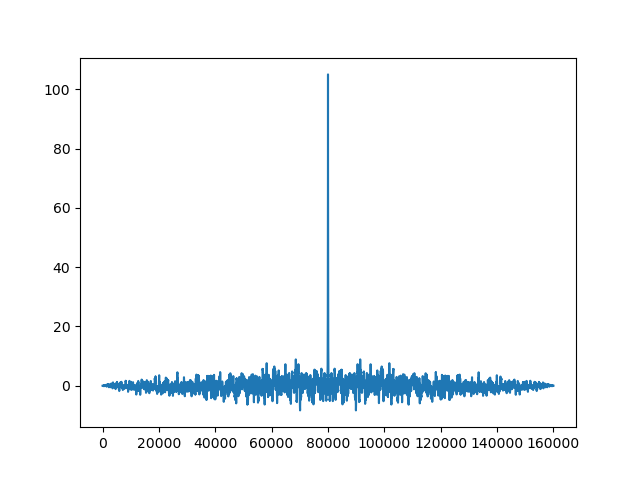

In [11]:
import scipy.signal as sig

pt.figure()
pt.plot(sig.correlate(a-np.mean(a),a-np.mean(a)))

### Create a "true" Markov-chain after removal of the burning period and after getting rid of correlation

In [12]:
a=a[0:-1:200]
b=b[0:-1:200]
a.shape

(400,)

<IPython.core.display.Javascript object>


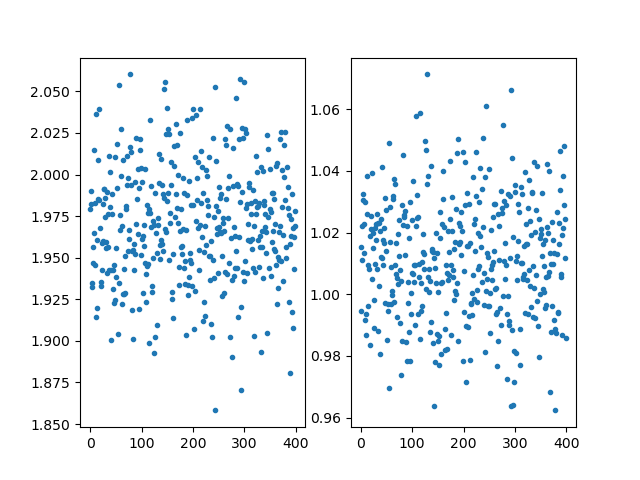

In [13]:
pt.figure()
pt.subplot(1,2,1)
pt.plot(a,'.')
pt.subplot(1,2,2)
pt.plot(b,'.')

In [14]:
print(mMAP,np.mean(a),np.mean(b))

[1.97316977 1.01051125] 1.9705105076053429 1.0114917561115087


## Represent histogram for slope and intercept

<IPython.core.display.Javascript object>


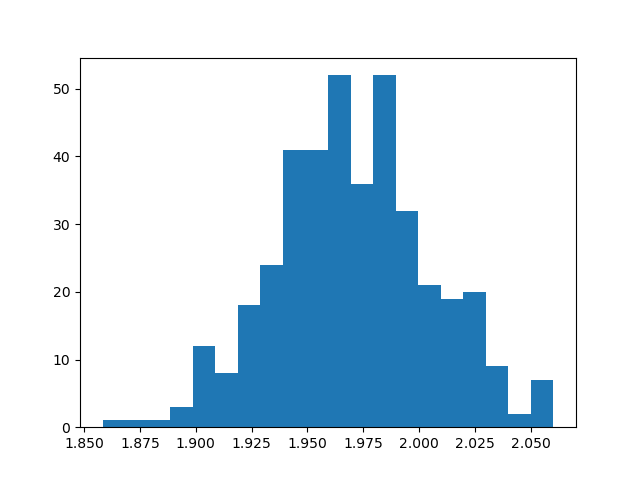

In [15]:
#hist, bins = np.histogram(mout[:, 2])
pt.figure()
#hist, bins = np.histogram(Z)
pt.hist(a,20);

<IPython.core.display.Javascript object>


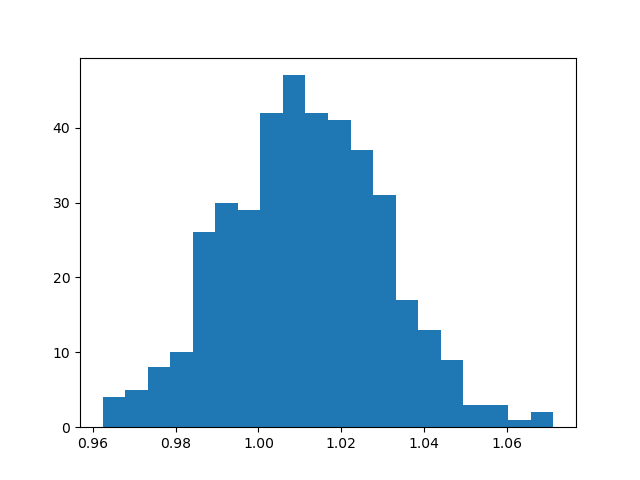

In [16]:
#hist, bins = np.histogram(mout[:, 2])
pt.figure()
#hist, bins = np.histogram(Z)
pt.hist(b,20);

In [17]:
def fn(ai,bi, a,b, x,sig):
    yi = ai * x + bi
    y = a * x + b
    res = (yi-y)/sig
    return np.sum(res)

In [18]:
tot = []
for i in range(len(a)):
    ai, bi = a[i], b[i]
    tot.append(fn(ai,bi, slope, intercept,my_problemLR.Xi,my_problemLR.sigmad))

<IPython.core.display.Javascript object>


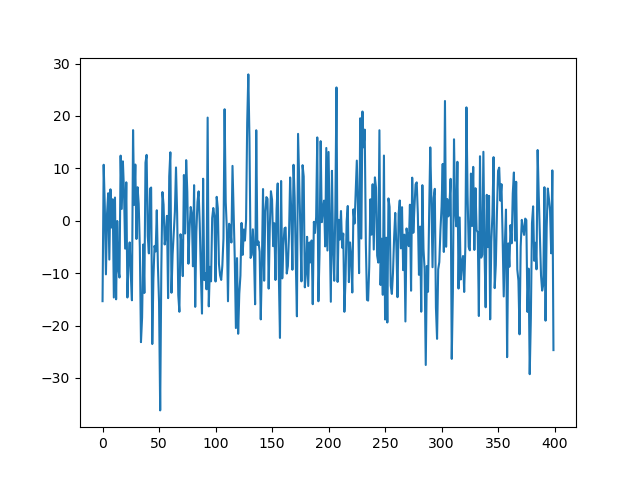

In [19]:
pt.figure()
pt.plot(tot)

# Distribution of posterior density function

(Source: https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3)

In [27]:
import scipy.stats as st

def get_best_distribution(data):
    
    dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang']
    
    dist_results = []
    
    params = {}
    
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        print('D=%.3f' % D)
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [28]:
get_best_distribution(a)

p value for weibull_min = 0.6860320824749293
D=0.035
p value for norm = 0.9654715709766104
D=0.024
p value for weibull_max = 0.8141171235761981
D=0.031
p value for beta = 0.9648996192174581
D=0.025
p value for invgauss = 0.8009458291500742
D=0.032
p value for uniform = 6.203149650413272e-22
D=0.247
p value for gamma = 0.967856256773359
D=0.024
p value for expon = 5.139528760527221e-48
D=0.364
p value for lognorm = 0.988213982905863
D=0.022
p value for pearson3 = 0.9681034726839393
D=0.024
p value for triang = 0.00027447038045471056
D=0.105
Best fitting distribution: lognorm
Best p value: 0.988213982905863
Parameters for the best fit: (0.015331108800409169, -0.3148526687703932, 2.2851424115437355)


('lognorm',
 0.988213982905863,
 (0.015331108800409169, -0.3148526687703932, 2.2851424115437355))

In [29]:
get_best_distribution(b)

p value for weibull_min = 0.9322984012036685
D=0.027
p value for norm = 0.9894359488388722
D=0.022
p value for weibull_max = 0.7850935268487369
D=0.032
p value for beta = 0.959372129143059
D=0.025
p value for invgauss = 0.24338187528926203
D=0.051
p value for uniform = 5.745863667793743e-20
D=0.235
p value for gamma = 0.9870674700532273
D=0.022
p value for expon = 2.8097481336440573e-32
D=0.299
p value for lognorm = 0.9871079849295906
D=0.022
p value for pearson3 = 0.9866513206622446
D=0.022
p value for triang = 0.0011013844431092597
D=0.096
Best fitting distribution: norm
Best p value: 0.9894359488388722
Parameters for the best fit: (1.0114917561115087, 0.019073066294001625)


('norm', 0.9894359488388722, (1.0114917561115087, 0.019073066294001625))